# Simulating Clifford randomized benchmarking using a generic noise model

This tutorial demonstrates shows how to simulate Clifford RB sequences using arbitrary $n$-qubit process matrices.  In this example $n=2$.

In [1]:
from __future__ import print_function #python 2 & 3 compatibility

import pygsti
from pygsti.extras import rb

Welcome to pygsti version 0.9.7!
There have been some major changes between this version and 0.9.6 - ones that break backward compatibility.  If you're trying to run an old script and nothing works, DON'T PANIC; we've tried to make the transition easy.  More often then not, you can just run `pyGSTi/scripts/upgrade2v0.9.7.py` on your old script or notebook files and you'll be up and running again.  For more information, see the pyGSTi FAQ.ipynb.

If this warning annoys you run:
  `export PYGSTI_BACKCOMPAT_WARNING=0` from the command line or
  `import os; os.environ['PYGSTI_BACKCOMPAT_WARNING'] = '0'` in a script or
     notebook *before* importing pygsti and the the madness will stop.


## Get some CRB circuits

First, we follow the [Clifford RB](../CliffordRB.ipynb) tutorial to generate a set of sequences.  If you want to perform Direct RB instead, just replace this cell with the contents of the [Direct RB](../DirectRB.ipynb) tutorial up until the point where it creates `circuitlist`:

In [2]:
#Specify the device to be benchmarked - in this case 2 qubits
nQubits = 2
qubit_labels = [0,1] 
gate_names = ['Gx', 'Gy','Gcphase'] 
availability = {'Gcphase':[(0,1)]}
pspec = pygsti.obj.ProcessorSpec(nQubits, gate_names, availability=availability, 
                                 qubit_labels=qubit_labels)

#Specify RB parameters (k = number of repetitions at each length)
lengths = [0,1,2,4,8,16]
k = 10
subsetQs = [0,1]
randomizeout = False # ==> all circuits have the *same* ideal outcome (the all-zeros bitstring)

#Generate clifford RB circuits
exp_dict = rb.sample.clifford_rb_experiment(pspec, lengths, k, subsetQs=subsetQs, randomizeout=randomizeout)

#Collect all the circuits into one list:
circuitlist = [exp_dict['circuits'][m,i] for m in lengths for i in range(k)]

- Sampling 10 circuits at CRB length 0 (1 of 6 lengths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 1 (2 of 6 lengths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 2 (3 of 6 lengths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 4 (4 of 6 lengths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 8 (5 of 6 lengths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,
- Sampling 10 circuits at CRB length 16 (6 of 6 lengths)
  - Number of circuits sampled = 1,2,3,4,5,6,7,8,9,10,


## Create a model to simulate these circuits
Now we need to create a model that can simulate circuits like this.  Two things to note:

1. RB circuits use our "multi-qubit" gate naming, so you have gates like `Gx:0` and `Gcphase:0:1`.
2. RB circuits do gates in parallel (this only matters for >1 qubits), so you have layers like `[Gy:0Gy:1]`

In this example, we'll make a model with $n$-qubit process matrices, so this will be practically limited to small $n$.  We construct a model based on our standard 2-qubit X, Y, and CPHASE model, since this 
has all the appropriate gates.  To get a model with the multi-qubit labels, we'll morph our "standard"
module into a "standard multi-qubit" module, which has the same stuff in it but uses the multi-qubit
naming conventions, to match point 1. above.  If you can't start with a standard model, then you'll need to create an `ExplicitOpModel` object of the appropriate dimension (see the [explicit models tutorial](../../objects/ExplicitModel.ipynb)) and assign to it gates with are, for instance `('Gx',0)` rather than just `'Gx'`.

Here's how we do the morphing:

In [3]:
import numpy as np
from pygsti.construction import std2Q_XYCPHASE
smq2Q_XYCPHASE = pygsti.construction.stdmodule_to_smqmodule(std2Q_XYCPHASE)

Now the `smq2Q_XYCPHASE` module acts just like the usual `std2Q_XYCPHASE` one but with multi-qubit conventions.  We'll depolarize the target model and set one of the process matrices to a custom value as a demonstration.  Here is where you can set any 2-qubit process matrices you want to any of the gates:

In [4]:
myModel = smq2Q_XYCPHASE.target_model().depolarize(op_noise=0.01, spam_noise=0.01)
myModel[('Gx',0)] = np.kron( 
    np.array([[1, 0, 0, 0],
              [0, 0.85, 0, 0],
              [0, 0, 0, -0.85],
              [0, 0, 0.85, 0]], 'd'),
    np.array([[1, 0, 0, 0],
              [0, 0.95, 0, 0],
              [0, 0, 0.95, 0],
              [0, 0, 0, 0.95]], 'd'))
#print(myModel[('Gx',0)])
myModel.operations.keys() #voila! you have gates like "Gx:0" rather than "Gxi"

odict_keys([Label[Gx:1], Label[Gy:1], Label[Gx:0], Label[Gy:0], Label[Gcphase:0:1]])

Since, `ExplicitOpModel` don't know how to automatically simulate multiple gates in parallel (you'd need to add an operation for each layer explicitly), we'll just *serialize* the circuits so they don't contain any parallel gates.  This addresses point 2) above.  Then we can simulate our circuits using our `ExplicitOpModel`, creating a `DataSet`.

In [5]:
serial_circuits = [c.serialize() for c in circuitlist]
ds = pygsti.construction.generate_fake_data(myModel, serial_circuits, 100, seed=1234)

#See how the DataSet contains serialized circuits (just printing the first several layers for clarity)
print(ds.keys()[10][0:7])
print(circuitlist[10][0:5])

Qubit 0 ---|  |-|Gx|-|Gy|-|C1|-|Gy|-|  |-|  |---
Qubit 1 ---|Gy|-|  |-|  |-|C0|-|  |-|Gx|-|Gy|---

Qubit 0 ---|Gx|-|Gy|-|C1|-|Gy|-|  |---
Qubit 1 ---|Gy|-|  |-|C0|-|Gx|-|Gy|---



## Running RB on the simulated `DataSet`
To run an RB analysis, we need to collect the "success" outcome counts for each circuit.  We just build up parallel lists as show below, using the `'idealout'` key (even though it's always the same in this case) of `exp_dict` to determine what outcome we were supposed to get.  These parallel lists can be used to initialize a `RBSummaryDataSet` object.

In [6]:
lengthslist = []
counts = []
scounts = []
cdepths = []
c2Qgatecnts = []

for m in lengths:
    for i in range(k):
        c = exp_dict['circuits'][m,i]
        ideal_outcome = ''.join(map(str,exp_dict['idealout'][m,i]))
        serial_c = c.serialize()
        datarow = ds[serial_c]
        lengthslist.append(m)
        counts.append(datarow.total)
        scounts.append(datarow[ideal_outcome])
        cdepths.append(c.depth())
        c2Qgatecnts.append(c.twoQgate_count())

#Then we can create a RBSummaryDataset object, which contains all the info needed to perform 
# our standard RB analyses:
data = rb.results.RBSummaryDataset(nQubits, lengthslist, success_counts=scounts, total_counts=counts,
                             circuit_depths=cdepths, circuit_twoQgate_counts=c2Qgatecnts)

One we have a `RBSummaryDataSet`, we can just follow the final steps of the [RB analysis tutorial](../RBAnalysis.ipynb) to perform a standard RB analysis and plot the results.

In [7]:
#Do a standard RB analysis
rbresults = rb.analysis.std_practice_analysis(data)

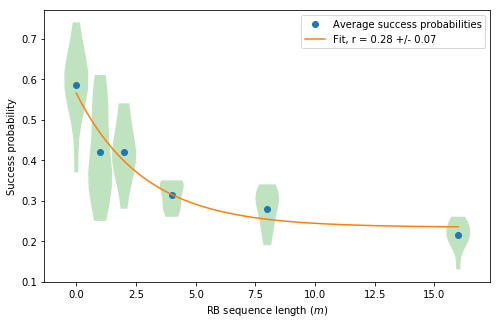

In [8]:
#Plot some stuff, etc - see the RBAnalysis.ipynb for more on this.
%matplotlib inline
rbresults.plot()